In [ ]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
from datetime import datetime

## Webscrapping Yahoo Finance

In [14]:
#get the URL using response variable
headers = { 'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36' } 
url = "https://finance.yahoo.com/quote/%5EGSPC/history/?period1=1558974659&period2=1716827454"
response = requests.get(url,headers=headers)

#testing if connectiong works
print("response.ok : {} , response.status_code : {}".format(response.ok , response.status_code))
print("Preview of response.text : ", response.text[:500])


response.ok : True , response.status_code : 200
Preview of response.text :  <!doctype html>
<html lang="en-US" theme="light"  data-color-scheme="light" class="desktop neo-green">
    <head>
        <meta charset="utf-8" />
        <meta name="viewport" content="width=device-width, initial-scale=1" />
        <meta name="oath:guce:consent-host" content="guce.yahoo.com" />
        <link rel="manifest" href="/manifest.json" />
        
		<link href="../../../assets/_app/immutable/assets/2.InAwsAwu.css" rel="stylesheet">
		<link href="../../../assets/_app/immutable/assets/A


In [29]:
page_content = response.text
doc = BeautifulSoup(page_content, 'lxml')
doc_items = list(doc.descendants)

In [39]:
td_elements = doc.find_all('td', class_='svelte-ewueuo')
td_elements[:10]

[<td class="svelte-ewueuo">May 24, 2024</td>,
 <td class="svelte-ewueuo">5,281.45</td>,
 <td class="svelte-ewueuo">5,311.65</td>,
 <td class="svelte-ewueuo">5,278.39</td>,
 <td class="svelte-ewueuo">5,304.72</td>,
 <td class="svelte-ewueuo">5,304.72</td>,
 <td class="svelte-ewueuo">3,005,510,000</td>,
 <td class="svelte-ewueuo">May 23, 2024</td>,
 <td class="svelte-ewueuo">5,340.26</td>,
 <td class="svelte-ewueuo">5,341.88</td>]

In [83]:
results = []
for i in range(0, len(td_elements), 7):
    date = td_elements[i].get_text()
    date_numeric = datetime.strptime(date, '%b %d, %Y').strftime('%Y-%m-%d')
    fifth_element = td_elements[i + 4].get_text()
    results.append((date_numeric, fifth_element))

# Print the results
results[:30]

[('2024-05-24', '5,304.72'),
 ('2024-05-23', '5,267.84'),
 ('2024-05-22', '5,307.01'),
 ('2024-05-21', '5,321.41'),
 ('2024-05-20', '5,308.13'),
 ('2024-05-17', '5,303.27'),
 ('2024-05-16', '5,297.10'),
 ('2024-05-15', '5,308.15'),
 ('2024-05-14', '5,246.68'),
 ('2024-05-13', '5,221.42'),
 ('2024-05-10', '5,222.68'),
 ('2024-05-09', '5,214.08'),
 ('2024-05-08', '5,187.67'),
 ('2024-05-07', '5,187.70'),
 ('2024-05-06', '5,180.74'),
 ('2024-05-03', '5,127.79'),
 ('2024-05-02', '5,064.20'),
 ('2024-05-01', '5,018.39'),
 ('2024-04-30', '5,035.69'),
 ('2024-04-29', '5,116.17'),
 ('2024-04-26', '5,099.96'),
 ('2024-04-25', '5,048.42'),
 ('2024-04-24', '5,071.63'),
 ('2024-04-23', '5,070.55'),
 ('2024-04-22', '5,010.60'),
 ('2024-04-19', '4,967.23'),
 ('2024-04-18', '5,011.12'),
 ('2024-04-17', '5,022.21'),
 ('2024-04-16', '5,051.41'),
 ('2024-04-15', '5,061.82')]

In [116]:
df = pd.DataFrame(results,columns=['Date','Adj_Close'])
df['Adj_Close'] = df['Adj_Close'].str.replace(',', '')
df['Adj_Close'] = pd.to_numeric(df['Adj_Close'])
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date',inplace=True)
df.reset_index(inplace=True)
df = df.drop(columns='index')
df.head(5)

,Date,Adj_Close
0,2019-05-28,2802.39
1,2019-05-29,2783.02
2,2019-05-30,2788.86
3,2019-05-31,2752.06
4,2019-06-03,2744.45


In [117]:
df.to_csv('Adj_Close_SP500.csv',index=False)

## EDA Analysis

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns

In [133]:
df = pd.read_csv('Adj_Close_SP500.csv')
df.head(5)

,Date,Adj_Close
0,2019-05-28,2802.39
1,2019-05-29,2783.02
2,2019-05-30,2788.86
3,2019-05-31,2752.06
4,2019-06-03,2744.45


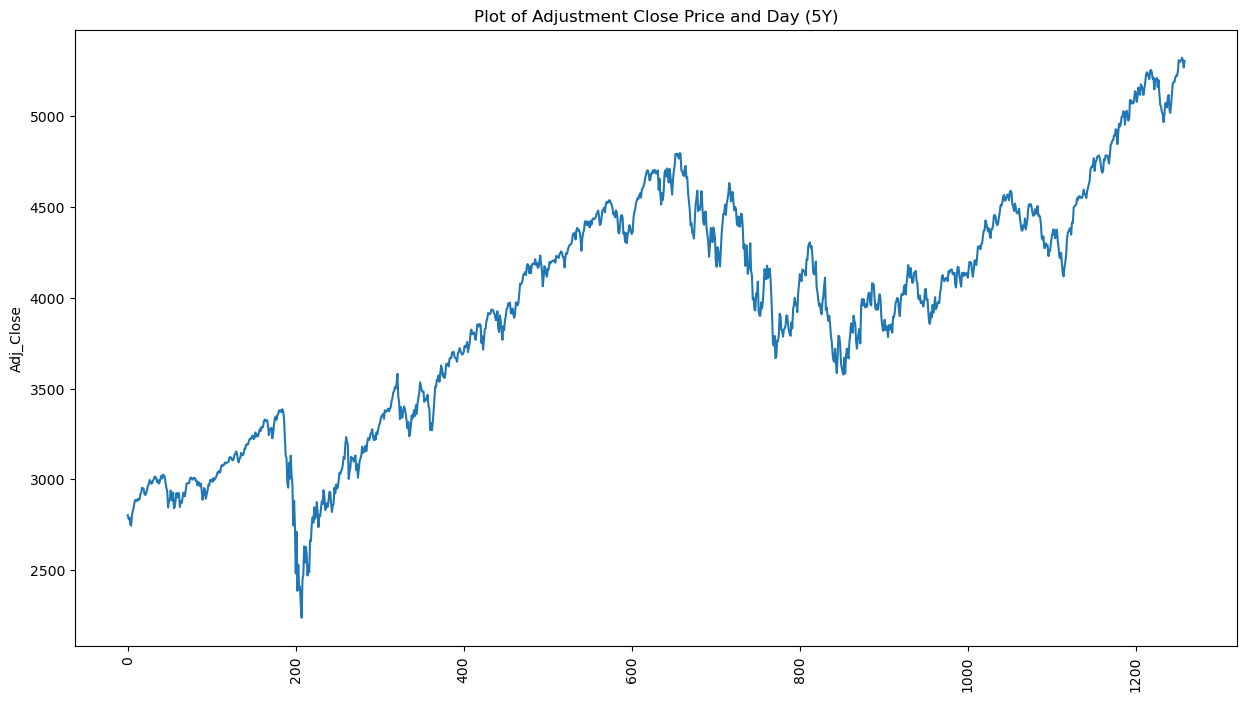

In [134]:
plt.figure(figsize=(15,8))
sns.lineplot(data=df,x=df.index,y='Adj_Close')
plt.xticks(rotation=90)
plt.title('Plot of Adjustment Close Price and Day (5Y)')
plt.show()

In [136]:
df.set_index('Date', inplace=True)
df.head(5)

,Adj_Close
Date,
2019-05-28,2802.39
2019-05-29,2783.02
2019-05-30,2788.86
2019-05-31,2752.06
2019-06-03,2744.45


## Modeling Using RNN

In [205]:
train = df.iloc[:900]
test = df.iloc[900:]

In [206]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Feature scaling
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Create sequences for the RNN
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

### Relu Activation, simple LSTM model

Epoch 1/30


C:\Users\zhaox\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2931 - val_loss: 0.0874
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0160 - val_loss: 0.0106
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045 - val_loss: 0.0026
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - val_loss: 8.8226e-04
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - val_loss: 9.0937e-04
Epoch 9/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - val_loss: 8.5249e-04
Epoch 10/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.6949e-04 - val_loss: 8.2738e-04
Epoch 11/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.0944e-04 - val_loss: 8.0612e-04
Epoch 12/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - los

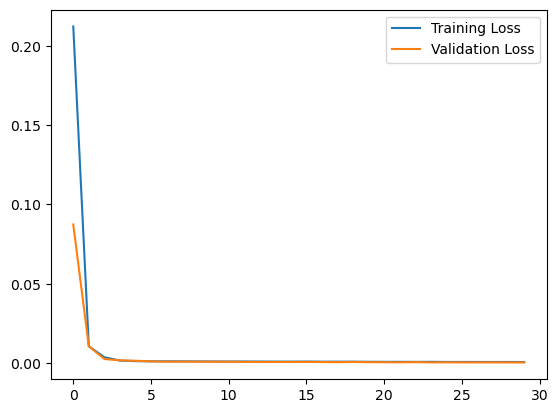

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


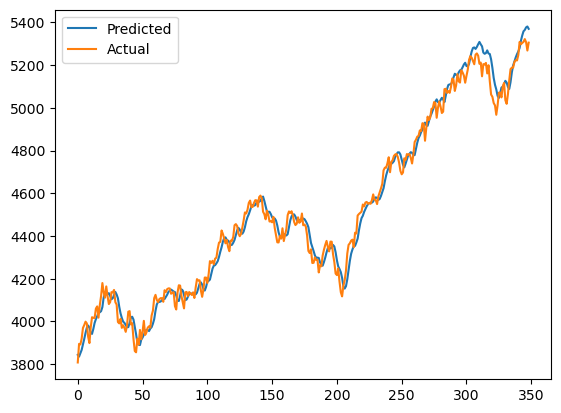

In [217]:
# Build the RNN model 1
model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Make predictions
predicted = model.predict(X_test)

# Inverse scaling for predictions and actual values
predicted = scaler.inverse_transform(predicted)
actual = scaler.inverse_transform(y_test)

# Plot predictions vs actual values
plt.plot(predicted, label='Predicted')
plt.plot(actual, label='Actual')
plt.legend()
plt.show()

In [218]:
rmse_RNN_simple = history.history['val_loss'][-1]

### Relu Activation, Multilayer with dropout functionality

Epoch 1/30


C:\Users\zhaox\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.2334 - val_loss: 0.0755
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0202 - val_loss: 0.0055
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0082 - val_loss: 0.0044
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0057 - val_loss: 0.0025
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0047 - val_loss: 0.0037
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0043 - val_loss: 9.6688e-04
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0045 - val_loss: 0.0036
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0041 - val_loss: 0.0025
Epoch 9/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0033 - val_loss: 9.3475e-04
Epoch 10/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0037 - val_loss: 9.3955e-04
Epoch 11/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0038 - val_loss: 8.6626e-04
Epoch 12/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss

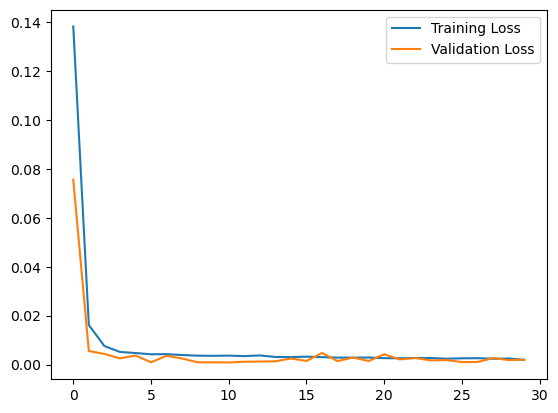

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


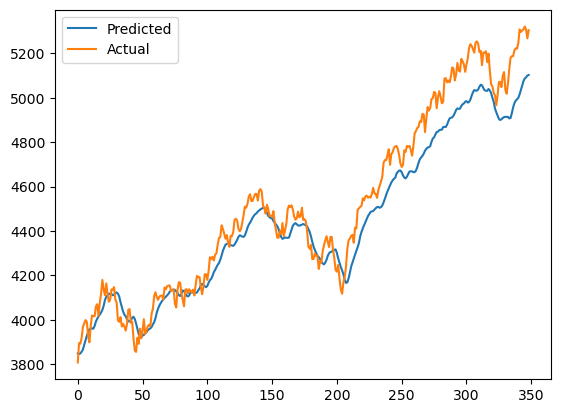

In [208]:
# Build the RNN model
model = Sequential([
    LSTM(units=100, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(units=100, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(units=100, activation='relu'),
    Dropout(0.2),
    Dense(units=50, activation='relu'),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Make predictions
predicted = model.predict(X_test)

# Inverse scaling for predictions and actual values
predicted = scaler.inverse_transform(predicted)
actual = scaler.inverse_transform(y_test)

# Plot predictions vs actual values
plt.plot(predicted, label='Predicted')
plt.plot(actual, label='Actual')
plt.legend()
plt.show()

In [209]:
rmse_RNN_complex = history.history['val_loss'][-1]

### LeakyReLU activation with negative slope = 0.1 and two layers

Epoch 1/30


C:\Users\zhaox\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.2718 - val_loss: 0.0540
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0148 - val_loss: 0.0017
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - val_loss: 7.3503e-04
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - val_loss: 8.6078e-04
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013 - val_loss: 7.5254e-04
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013 - val_loss: 6.2974e-04
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013 - val_loss: 8.8018e-04
Epoch 9/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - val_loss: 5.9442e-04
Epoch 10/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011 - val_loss: 6.5796e-04
Epoch 11/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 12/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - lo

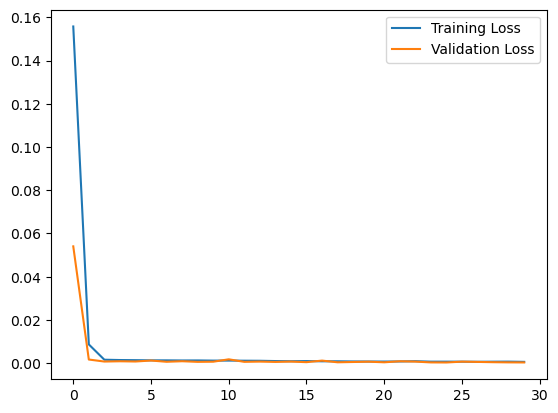

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


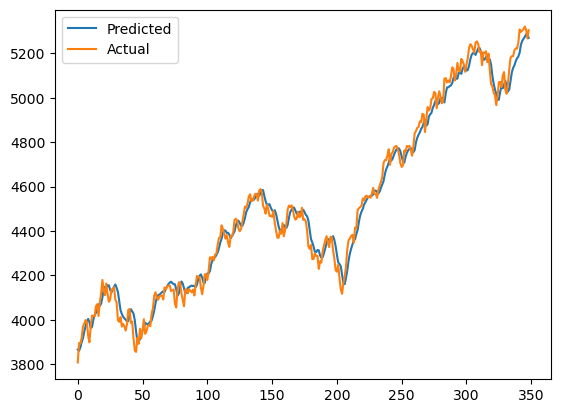

In [213]:
from tensorflow.keras.layers import LeakyReLU

# Build another RNN model with LeakyReLU and fewer dropout
model = Sequential([
    LSTM(units=100, activation=LeakyReLU(negative_slope=0.1), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(units=100, activation=LeakyReLU(negative_slope=0.1)),
    Dense(units=50, activation=LeakyReLU(negative_slope=0.1)),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Make predictions
predicted = model.predict(X_test)

# Inverse scaling for predictions and actual values
predicted = scaler.inverse_transform(predicted)
actual = scaler.inverse_transform(y_test)

# Plot predictions vs actual values
plt.plot(predicted, label='Predicted')
plt.plot(actual, label='Actual')
plt.legend()
plt.show()

In [214]:
rmse_RNN_LeakyRELU = history.history['val_loss'][-1]

## Model Evaluation

In [219]:
import pandas as pd
import numpy as np

# Define RMSE values for each model
rmse_values = {
    'Model': ['Simple RNN', 'Complex RNN', 'LeakyReluRNN'],
    'RMSE': [rmse_RNN_simple, rmse_RNN_complex, rmse_RNN_LeakyRELU]  # Replace with actual RMSE values
}

# Create DataFrame
rmse_df = pd.DataFrame(rmse_values)

# Display as a table
print(rmse_df)

          Model      RMSE
0    Simple RNN  0.000380
1   Complex RNN  0.001994
2  LeakyReluRNN  0.000316
